# Homework 3 Problem 2: 核磁共振造影的 3D 影像分析







在HW3的第二個問題中，以下的 TODO 需要在 notebook 中完成：







1. 調整適當的超參數







2. 使用預訓練模型時，請透過實驗決定：



   



    * 使用預訓練的權重，同時訓練過程不更新參數



  



    * 使用預訓練的權重作為起始值，且訓練過程會更新參數







3. 建立剩餘的兩個 2D CNN: Single slice model, Early fusion model。最後繳交的ipynb檔案中，需要有完成的Single slice model, Early fusion model, Late fusion model 和 3D CNN 這四個模型。







4. 調整適當的 optimizer、scheduler，**選擇scheduler的時候要注意到在train_one_epoch()中`scheduler.step()`是否在正確的位置。**







5. 為輸出的csv檔命名，需要標示清楚是使用哪個模型（late.csv, early.csv, single.csv, 3D.csv)







在 kaggle 競賽中：







1. 不得使用兩隻以上的帳號繳交 submission檔案 (可參加但不可丟答案)







2. team的名稱記得一定要改成學號

In [1]:
!pip install pydicom
!pip install torchsummary

In [2]:
import warnings
import gc
import os
import random

from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
import pydicom
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import models, transforms
from torchvision.transforms import v2
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

warnings.filterwarnings('ignore')

In [3]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    # Set NumPy random seed
    np.random.seed(seed)
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
class config:
    root = "/kaggle/input/mia-hw-3"
    valid_prob = 0.2
    batch_size = 4
    lr = 1e-3
    epochs = 30
    weight_decay = 1e-3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42

## Data

In [5]:
root = "/kaggle/input/mia-hw-3"
train_data = pd.read_csv(os.path.join(root, "train.csv"))
print(f"Numbers of train data : {len(train_data)}")
train_data.head(10)

Numbers of train data : 80


,ID,Disease
0,545876,0
1,517509,0
2,4194,0
3,8098,0
4,230450,0
5,193329,0
6,889904,0
7,1126761,1
8,310883,0
9,347447,0


In [6]:
train_data_label_dist = pd.DataFrame(
    {
        "label" : train_data.iloc[:, 1].value_counts().sort_index().index.astype(str),
        "counts" : train_data.iloc[:, 1].value_counts().sort_index().values
    }
)
train_data_label_dist

,label,counts
0,0,40
1,1,40


## Defined Image Interpolation

In [7]:
# image interpolation
class Interpolate():
    def __init__(self, target_num = 22):
        self.target_num = target_num
        
    def __call__(self, slices): # (3, XX, 512, 512) 其中 XX 是切片的數量
        slices = slices.unsqueeze(dim = 0) # (1, 3, XX, 512, 512)
        slices = F.interpolate(
                  slices, 
                  mode = 'trilinear',
                  size = (self.target_num, slices.shape[-2], slices.shape[-1])) # (1, 3, target_num, 512, 512) 其中 slices.shape[-2], slices.shape[-1]為 XX 張 slice 的 H, W

        return torch.transpose(slices.squeeze(), 0, 1) # slices.squeeze()的形狀為 (3, 22, 512, 512)， 經過 transpose 後形狀變為 (22, 3, 512, 512)

## Data Transformation

In [8]:
def build_transform(is_train):
    t = []
    if is_train:       
        t.append(Interpolate(target_num = 22))

        return v2.Compose(t)

    t.append(Interpolate(target_num = 22))
    
    return v2.Compose(t)

## Evaluator

In [9]:
def evaluator(preds, gts):
    preds = preds.cpu().detach().numpy() 
    gts = gts.cpu().numpy() 
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts, average="macro")

    return acc, f1

## Training

In [10]:
def train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    model.train()
    train_loss = .0
    predictions, ground_truths = [], []

    for images, labels in train_loader:
        images = [image.to(device=device, dtype=torch.float) for image in images]
        labels = labels.to(device=device, dtype=torch.long)
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        # scheduler.step()
        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        predictions.append(preds)
        ground_truths.append(labels)

    scheduler.step()

    train_loss /= len(train_loader)
    predictions = torch.cat(predictions)
    ground_truths = torch.cat(ground_truths)
    train_acc, train_f1 = evaluator(predictions, ground_truths)

    return train_loss, 100*train_acc, 100*train_f1

In [11]:
def plot_training_history(history):
    epochs = range(len(history["train"]["loss"]))
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history["train"]["loss"], label='Training Loss')
    plt.plot(epochs, history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history["train"]["acc"], label='Training Accuracy')
    plt.plot(epochs, history["valid"]["acc"], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # F1 Score plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history["train"]["f1"], label='Training F1')
    plt.plot(epochs, history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.title('Training and Validation F1 Score')

    plt.tight_layout()
    plt.show()

## Validation

In [12]:
def validation(model, valid_loader, criterion, device):
    model.eval()
    valid_loss = .0
    predictions, ground_truths = [], []

    with torch.no_grad():
        for images, labels in valid_loader:
            images = [image.to(device=device, dtype=torch.float) for image in images]
            labels = labels.to(device=device, dtype=torch.long)

            logits = model(images)
            loss = criterion(logits, labels)
            valid_loss += loss.item()
            preds = torch.argmax(logits, dim=1)

            predictions.append(preds)
            ground_truths.append(labels)

        valid_loss /= len(valid_loader)

        predictions = torch.cat(predictions)
        ground_truths = torch.cat(ground_truths)
        valid_acc, valid_f1 = evaluator(predictions, ground_truths)

    return valid_loss, 100*valid_acc, 100*valid_f1

## Testing

In [13]:
def testing(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for images in test_loader:
            images = [image.to(device=device, dtype=torch.float) for image in images]
            logits = model(images)
            pred = torch.argmax(logits, dim=1)

            preds.append(pred)

    preds = torch.cat(preds)

    return preds

# 2D CNN



## 2D Dataset

**前次的code修改**











上次說整個 2D dataset 的 images 是一個放 22 * 80 個大小為 (3, 256, 256) 切片影像的 list。







2DDataset = [(3,256,256), (3,256,256), (3,256,256), ...,(3,256,256)]







但應該是存放 80 個元素的 list，其中這些元素都是一個叫 image 的 list，裡面存放 22 個大小為 (3, 256, 256) 切片影像，這樣才方便進行後續的 2D CNN 訓練。







2DDataset = [image, image, ..., image], image = [(3,256,256), (3,256,256), ...,(3,256,256)]

In [14]:
class MRI2DDataset(Dataset):
    def __init__(self, df, mode = None, transforms = None):
        root = "/kaggle/input/mia-hw-3"
        self.ids = np.array(df["ID"])
        self.labels = torch.from_numpy(np.array(df["Disease"]))
        self.mode = mode
        self.transforms = transforms

        paths = []
        for ID in np.array(df["ID"]):
            path = os.path.join(root, "DICOM", str(ID).split('.')[0].zfill(7))
            paths.append(path)
            
        self.images = []
        for path in tqdm(paths):
            all_slices = []
            T1_root = os.path.join(path, "T1")
            for filename in sorted(os.listdir(T1_root), key = lambda s: int(pydicom.dcmread(os.path.join(T1_root, s)).InstanceNumber)):
                T1_image = []
                T2_image = []
                
                # T1 images
                img = pydicom.dcmread(os.path.join(T1_root, filename))
                ww = img.WindowWidth
                wc = img.WindowCenter
                highest_visible_value = (ww + 2 * wc) / 2
                lowest_visible_value = highest_visible_value - ww
                img = img.pixel_array
                img = np.clip(img, lowest_visible_value, highest_visible_value)
                img = 255 * (img - lowest_visible_value) / ww
                img = cv2.resize(img, (256, 256))
                T1_image.append(img)
                
                # T2 images
                img = pydicom.dcmread(os.path.join(path, "T2", filename))
                ww = img.WindowWidth
                wc = img.WindowCenter
                highest_visible_value = (ww + 2 * wc) / 2
                lowest_visible_value = highest_visible_value - ww
                img = img.pixel_array
                img = np.clip(img, lowest_visible_value, highest_visible_value)
                img = 255 * (img - lowest_visible_value) / ww
                img = cv2.resize(img, (256, 256))
                T2_image.append(img)
                
                # T1T2 images
                T1T2_image = (T1_image[0] + T2_image[0]) / 2
                T1T2_image = torch.tensor(T1T2_image)

                T1_image = torch.tensor(T1_image[0])
                T2_image = torch.tensor(T2_image[0])

                all_slices.append(torch.stack((T1_image, T2_image, T1T2_image), dim = 0))

            slices = torch.stack(all_slices, dim = 1)
            if self.transforms:
                slices = self.transforms(slices) 

            # 這邊有修改
            image = []
            for i in range(len(slices)):
                image.append(slices[i].squeeze().float()) 
            self.images.append(image)

    def __getitem__(self, index):
        if self.mode == "train":
            images = self.images[index]
            label = self.labels[index]    
            
            return images, label
        elif self.mode == "valid":
            images = self.images[index]
            label = self.labels[index]
            
            return images, label
        
        elif self.mode == "test":
            images = self.images[index]
            
            return images
        
    def __len__(self):
        return(len(self.ids))

In [15]:
df = pd.read_csv(os.path.join(config.root, "train.csv"))
# split training & validation dataset 
n = df.shape[0]
valid_size = int(n * config.valid_prob)
train_ids , valid_ids = train_test_split(
    np.linspace(0, n - 1, n).astype("int"),
    test_size = valid_size,
    random_state = config.seed,
)

print("Initializing dataset...")  
train_df = df.iloc[train_ids]
valid_df = df.iloc[valid_ids]
train_dataset = MRI2DDataset(train_df, mode = "train",transforms = build_transform(True))
valid_dataset = MRI2DDataset(valid_df, mode = "valid",transforms = build_transform(False))

# DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)

Initializing dataset...


100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


In [16]:
seed_everything(config.seed)
test_df = pd.read_csv(os.path.join(config.root, "test.csv"))
test_dataset = MRI2DDataset(test_df, mode = "test",transforms = build_transform(False))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

# del test_dataset
# gc.collect()
# torch.cuda.empty_cache()

100%|██████████| 40/40 [00:40<00:00,  1.00s/it]


## Late Fusion

In [17]:
class config:
    root = "/kaggle/input/mia-hw-3"
    valid_prob = 0.2  # 驗證集的比例
    batch_size = 4   # 批量大小
    lr = 1e-4         # 學習率
    epochs = 30       # 訓練輪數
    weight_decay = 1e-5 # 權重衰減
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42         # 隨機種子
print(config.device)

cuda


### Late fusion model

所謂 Late Fusion 是指將 n 張 2D 影像分別提取特徵，得到 n 個特徵圖後在後期融合，而做法分成兩種：**with FC layers, with pooling**。







* **Late Fusion:**











首先對每個切片（slice）使用 2D CNN 提取特徵，然後將提取的特徵拼接起來然後攤平，接著將攤平完的結果直接輸入到 classifier 中的線性層（Linear）。

In [18]:
class Late_fusion(nn.Module):
    def __init__(self, num_classes, input_size = (3, 256, 256), features_grad = False): 
        super().__init__()
        # 取出vgg16中的特徵層
        vgg16 = models.vgg16(weights='IMAGENET1K_V1', progress = True)
        # 將 VGG16 的 classifier 層替換為 nn.Identity()，丟棄預設的分類層。
        vgg16.classifier = nn.Identity()
        # 可調整 feature map 的大小，可以改變參數量，但注意到會影響分類層
        # vgg16.avgpool = nn.AdaptiveAvgPool2d(output_size=(,))
        vgg16.avgpool = nn.AdaptiveAvgPool2d(output_size=(2, 2))  # Adjustable
        # 固定/不固定特徵層的參數值
        # 若 features_grad 設置為 FALSE，使用預訓練的 VGG16 特徵參數值，表示在訓練時參數將不會被更新
        # 若 features_grad 設置為 True，將利用預訓練的權重作為起點，然後讓模型根據本次的資料集進行調整。
        for param in vgg16.features.parameters():
            param.requires_grad = features_grad
        self.backend = vgg16

        # vgg16 最後一層通過 avgpool 後，每張 2D影像產生一個 (512, 7, 7) 的 feature map，共 22 個
        # 另外我們會對 22 張 feature map 進行拼接再攤平，得到一個長度為 512 * 22 * 7 * 7 的特徵向量
        # 增加分類層
        self.classifier = nn.Sequential(
            nn.Linear(512 * 22 * 2 * 2, 1024),  # Adjusted input dimension
            nn.ReLU(),
            nn.Dropout(0.5),  # Add Dropout
            nn.Linear(1024, num_classes)  # Final classification layer
        )
    # 在 PyTorch 中，forward 函數在 nn.Module 類的子類中是用來定義模型前向傳播過程的函數。這個函數描述了當 input 輸入模型時，如何一步一步地經過各層，最後輸出 outputs。 
    def forward(self, x): # x: 22 個 (batch_size, 3, 256, 256) 的 list
        feature_map_list = []
        for i in range(len(x)):
            feature_map_list.append(self.backend(x[i]))
        feature_map_concentrate = torch.cat(feature_map_list, dim=1)  # shape: (batch_size, 512 * 22, 7, 7)
        feature_map_concentrate = feature_map_concentrate.view(feature_map_concentrate.size(0), -1)  # shape: (batch_size, 512 * 22 * 7 * 7)
        outputs = self.classifier(feature_map_concentrate)

        return outputs

### Parameters of Late fusion model

In [19]:
model_late = Late_fusion(num_classes = 2)
total_params = sum(p.numel() for p in model_late.parameters())
print("總參數量:", total_params)
del model_late

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:19<00:00, 27.7MB/s] 


總參數量: 60855106


### Late fusion main

Initializing model...
num_classes 2
Start training!
Epoch[1/30], Train Loss: 2.9779, Train Accuracy: 57.81%, Train F1: 57.55% | Valid Loss: 0.7101, Valid Accuracy: 56.25%, Valid F1: 36.00% | LR: 0.000100
Epoch[2/30], Train Loss: 0.7545, Train Accuracy: 53.12%, Train F1: 52.94% | Valid Loss: 0.6242, Valid Accuracy: 68.75%, Valid F1: 67.61% | LR: 0.000100
Epoch[3/30], Train Loss: 0.7489, Train Accuracy: 53.12%, Train F1: 53.12% | Valid Loss: 0.6331, Valid Accuracy: 93.75%, Valid F1: 93.73% | LR: 0.000100
Epoch[4/30], Train Loss: 0.6013, Train Accuracy: 65.62%, Train F1: 63.90% | Valid Loss: 0.7697, Valid Accuracy: 56.25%, Valid F1: 36.00% | LR: 0.000100
Epoch[5/30], Train Loss: 0.6000, Train Accuracy: 71.88%, Train F1: 71.63% | Valid Loss: 0.5889, Valid Accuracy: 75.00%, Valid F1: 73.33% | LR: 0.000100
Epoch[6/30], Train Loss: 0.7018, Train Accuracy: 68.75%, Train F1: 68.25% | Valid Loss: 0.9389, Valid Accuracy: 43.75%, Valid F1: 30.43% | LR: 0.000100
Epoch[7/30], Train Loss: 0.6863, Tra

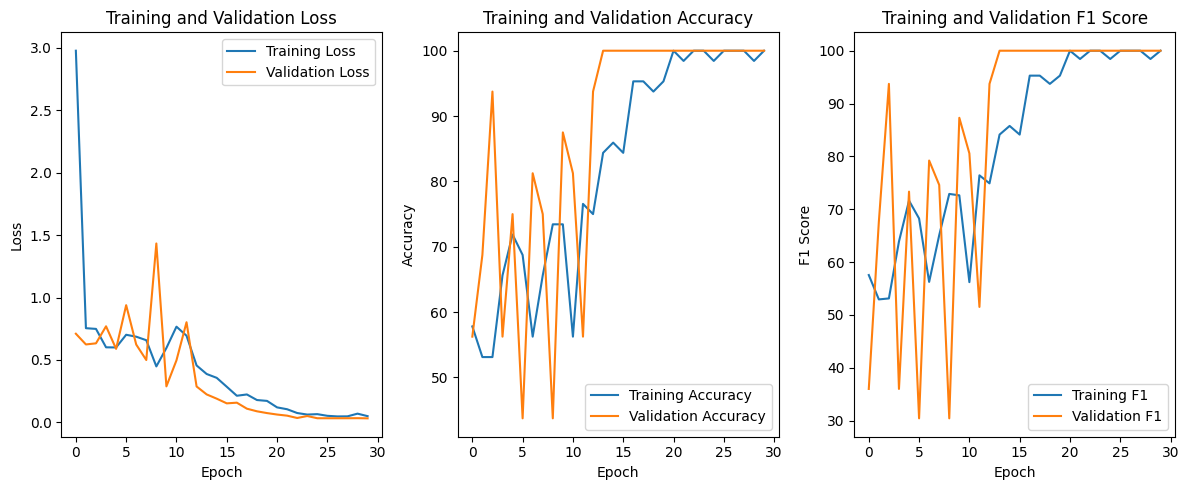

In [20]:
def main():
    seed_everything(config.seed)
    global train_loader, valid_loader
    # settings
    print("Initializing model...")
    num_classes = 2
    print('num_classes',num_classes)
    model_late = Late_fusion(num_classes = num_classes, features_grad = True)
    model_late.to(config.device)
    
    # 散則適當的criterion, optimizer
    criterion = nn.CrossEntropyLoss().to(config.device)
    optimizer = torch.optim.Adam(model_late.parameters(), lr = config.lr, weight_decay = config.weight_decay)

    # 以 epoch 為單位來更新學習率
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.1)

    # 以 batch 為單位來更新學習率
    # scheduler = torch.optim.lr_scheduler.OneCycleLR(
    #     optimizer = optimizer,
    #     epochs = config.epochs,
    #     steps_per_epoch = train_loader.__len__(),
    #     max_lr = config.lr,
    #     anneal_strategy = 'cos'
    # )

    # recordings
    best_val_loss = float("inf")
    history = {
      "train": {
          "loss": [],
          "acc": [],
          "f1": []
      },
      "valid": {
          "loss": [],
          "acc": [],
          "f1": []
      },
    }

    print("Start training!")
    
    for epoch in range(config.epochs):
        train_loss, train_acc, train_f1 = train_one_epoch(model_late, train_loader, optimizer, scheduler, criterion, config.device)
        valid_loss, valid_acc, valid_f1 = validation(model_late, valid_loader, criterion, config.device)
        # Log the loss and validation result
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)
        
        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')
        if valid_loss < best_val_loss:
            save_file = {
                "model": model_late.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpoint_Late.pth")

        best_ckpt = torch.load("checkpoint_Late.pth", map_location=config.device)
        model_late.load_state_dict(best_ckpt["model"])
        
    valid_loss, valid_acc, valid_f1 = validation(model_late, valid_loader, criterion, config.device)
    print("*"*10, " Validation ", "*"*10)
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%")
    
    # 清理資源
    # del train_loader, valid_loader, train_dataset, valid_dataset
    gc.collect()
    torch.cuda.empty_cache()
    
    
    # Plot training history
    plot_training_history(history)

if __name__ == "__main__":
    main()

In [21]:
model = Late_fusion(num_classes = 2, features_grad = True)
model.to("cuda")
best_ckpt = torch.load(f"checkpoint_Late.pth")
model.load_state_dict(best_ckpt["model"])
preds = testing(model, test_loader, config.device)

results_df = pd.read_csv(os.path.join(config.root, "submission.csv"))
results_df['Disease'] = preds.cpu().numpy() 
results_df.to_csv("late.csv", index=False)
results_df

,ID,Disease
0,1035303,0
1,1032110,1
2,3158,1
3,759590,0
4,903423,1
5,629424,1
6,984633,0
7,908999,1
8,11338,1
9,1070273,0


## Single Slice

In [22]:
class config:
    root = "/kaggle/input/mia-hw-3"
    valid_prob = 0.2  # 驗證集的比例
    batch_size = 4   # 批量大小
    lr = 1e-4         # 學習率
    epochs = 30       # 訓練輪數
    weight_decay = 1e-5 # 權重衰減
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42         # 隨機種子
print(config.device)

cuda


### Single slice model

In [23]:
class Single_slice(nn.Module):
    def __init__(self, num_classes, input_size=(3, 50, 50), features_grad=False):
        super().__init__()
        # Initialize VGG16 as the feature extractor
        vgg16 = models.vgg16(weights='IMAGENET1K_V1', progress=True)
        vgg16.classifier = nn.Identity()

        # Freeze or unfreeze VGG16 feature layers based on `features_grad`
        for param in vgg16.features.parameters():
            param.requires_grad = features_grad
        self.backend = vgg16

        # Define a global average pooling layer to reduce feature map dimensions
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # Outputs a 1x1 feature map per channel

        # Define a classifier for the extracted features
        self.classifier = nn.Linear(512, num_classes)  # 512 is the number of output channels from VGG16
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):  # x: list of 22 tensors, each of shape (batch_size, 3, 256, 256)
        softmax_outputs = []
        for i, slice_tensor in enumerate(x):
            # Print shape of each slice
            # print(f"Shape of slice {i}: {slice_tensor.shape}")
            # Extract feature map from VGG16
            feature_map = self.backend(slice_tensor)
            # print(f"Feature map shape after VGG16: {feature_map.shape}")
            
            # Reshape the feature map back to [batch_size, 512, 7, 7] before pooling
            feature_map = feature_map.view(-1, 512, 7, 7)
            # print(f"Reshaped feature map for pooling: {feature_map.shape}")

            # Apply global average pooling to reduce feature map to shape (batch_size, 512)
            pooled_features = self.global_pool(feature_map).squeeze(-1).squeeze(-1)  # Removes the 1x1 dimensions
            # print(f"Pooled features shape: {pooled_features.shape}")

            # Ensure the pooled features have the correct dimensions
            if pooled_features.dim() != 2:
                print(f"Unexpected tensor shape after pooling: {pooled_features.shape}")
                continue  # Skip this slice if shape is incorrect

            # Ensure the shape is (batch_size, 512) before passing to classifier
            assert pooled_features.shape[1] == 512, f"Expected shape (batch_size, 512), got {pooled_features.shape}"

            # Pass feature map through classifier and apply softmax
            softmax_output = self.softmax(self.classifier(pooled_features))
            softmax_outputs.append(softmax_output)

        # Average the softmax outputs across all slices
        output = torch.stack(softmax_outputs).mean(dim=0)
        
        # Take the log of the averaged output for compatibility with NLLLoss
        log_output = torch.log(output + 1e-10)  # Adding epsilon to avoid log(0)

        

        return log_output

如何完成 Single_slice 的 forward function，請透過下方的步驟：







- Step1: 對 x[i] 提取特徵得到 feature map







- Step2: 將 22 張 feature map 各自通過 classifier 並作 softmax







- Step3: 將 22 個 softmax 完的結果進行進行平均得到 output







- Step4: 將 Step3 得到的結果取 log 並輸出成 log_output，讓後續 nn.NLLLoss() 運行正常







**Hint of Step1,2,3: 用一個迴圈完成**







**Hint of Step4: `log_output = torch.log(output + 1e-10)`，為了避免出現 log(0) 的情況**

### Parameters of Single slice model

In [24]:
model = Single_slice(num_classes=2, features_grad=True).to(config.device)

# 計算並打印總參數量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("總參數量:", total_params)
del model

總參數量: 14715714


### Single slice main







**過去使用`nn.CrossEntropyLoss()`是將模型輸出的 logits 進行 Softmax 再轉成 log 的形式再計算損失函數。Single slice model 是將 22 個結果進行平均，但如果對 logits 平均會有點不合理，因此我們在 model 的階段使用 `nn.Softmax` 來將 logits 變成機率的形式，再將平均的機率取 log，所以後續使用的 criterion 要改成使用 `nn.NLLLoss()` 計算損失。**







`nn.CrossEntropyLoss() 相當於 Softmax - Log - NLLLoss()`

Start training!
Epoch[1/30], Train Loss: 0.7453, Train Accuracy: 56.25%, Train F1: 54.66% | Valid Loss: 0.6265, Valid Accuracy: 62.50%, Valid F1: 60.00% | LR: 0.001000
Epoch[2/30], Train Loss: 0.6932, Train Accuracy: 53.12%, Train F1: 52.38% | Valid Loss: 0.7379, Valid Accuracy: 43.75%, Valid F1: 30.43% | LR: 0.001000
Epoch[3/30], Train Loss: 0.6984, Train Accuracy: 65.62%, Train F1: 63.90% | Valid Loss: 0.5847, Valid Accuracy: 56.25%, Valid F1: 36.00% | LR: 0.001000
Epoch[4/30], Train Loss: 0.6575, Train Accuracy: 57.81%, Train F1: 56.53% | Valid Loss: 0.6431, Valid Accuracy: 43.75%, Valid F1: 30.43% | LR: 0.001000
Epoch[5/30], Train Loss: 0.6462, Train Accuracy: 59.38%, Train F1: 59.22% | Valid Loss: 0.6447, Valid Accuracy: 43.75%, Valid F1: 30.43% | LR: 0.001000
Epoch[6/30], Train Loss: 0.6674, Train Accuracy: 59.38%, Train F1: 57.89% | Valid Loss: 0.6290, Valid Accuracy: 50.00%, Valid F1: 41.82% | LR: 0.001000
Epoch[7/30], Train Loss: 0.6758, Train Accuracy: 54.69%, Train F1: 54.59

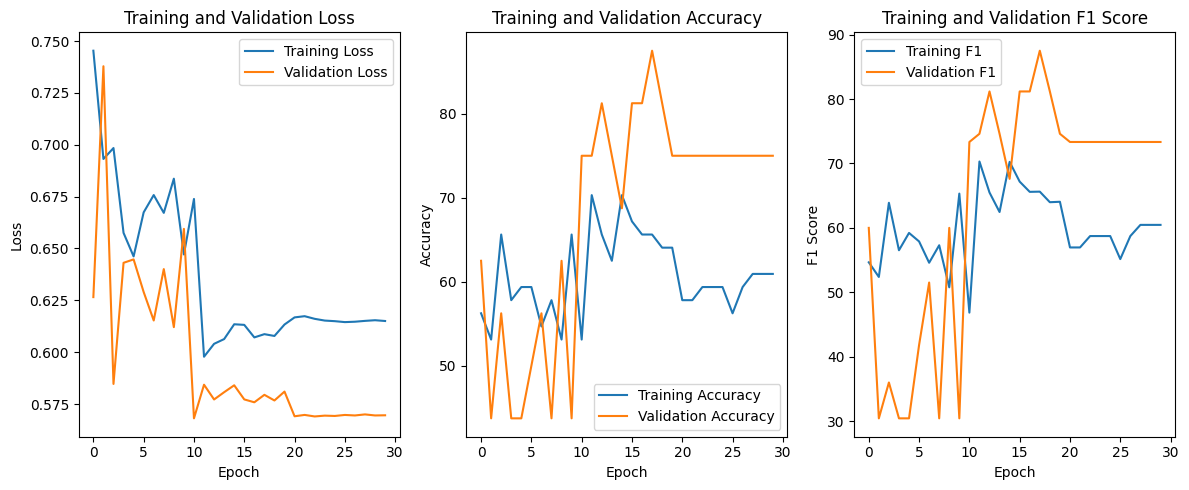

In [25]:
# nn.CrossEntropyLoss() 改成 nn.NLLLoss()---(未完成)
def main():
    # Step 1: Initialize the model, optimizer, and loss function
    num_classes = 2
    model = Single_slice(num_classes=num_classes, input_size=(3, 50, 50), features_grad=False).to(config.device)
    criterion = nn.NLLLoss()  # Use NLLLoss as the loss function since we're using log-probabilities
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    # Step 2: Initialize your datasets and data loaders
    seed_everything(config.seed)
    

    global train_loader, valid_loader

    # recordings
    best_val_loss = float("inf")
    history = {
      "train": {
          "loss": [],
          "acc": [],
          "f1": []
      },
      "valid": {
          "loss": [],
          "acc": [],
          "f1": []
      },
    }

    print("Start training!")
    
    for epoch in range(config.epochs):
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, config.device)
        valid_loss, valid_acc, valid_f1 = validation(model, valid_loader, criterion, config.device)
        # Log the loss and validation result
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)
        
        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')
        if valid_loss < best_val_loss:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpoint_Single.pth")

        best_ckpt = torch.load("checkpoint_Single.pth", map_location=config.device)
        model.load_state_dict(best_ckpt["model"])
        
    valid_loss, valid_acc, valid_f1 = validation(model, valid_loader, criterion, config.device)
    print("*"*10, " Validation ", "*"*10)
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%")
    
    # 清理資源
    # del train_loader, valid_loader, train_dataset, valid_dataset
    gc.collect()
    torch.cuda.empty_cache()
    
    
    # Plot training history
    plot_training_history(history)

if __name__ == "__main__":
    main()

In [26]:
model = Single_slice(num_classes = 2, features_grad = True)
model.to("cuda")
best_ckpt = torch.load(f"checkpoint_Single.pth")
model.load_state_dict(best_ckpt["model"])
preds = testing(model, test_loader, config.device)

results_df = pd.read_csv(os.path.join(config.root, "submission.csv"))
results_df['Disease'] = preds.cpu().numpy() 
results_df.to_csv("Single.csv", index=False)
results_df

,ID,Disease
0,1035303,0
1,1032110,1
2,3158,0
3,759590,1
4,903423,1
5,629424,1
6,984633,1
7,908999,1
8,11338,1
9,1070273,1


## Early Fusion

In [27]:
class config:
    root = "/kaggle/input/mia-hw-3"
    valid_prob = 0.2
    batch_size = 4
    lr = 1e-4
    epochs = 30
    weight_decay = 1e-5
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42

print(config.device)

cuda


### Early fusion model

In [28]:
class Early_fusion(nn.Module):
    def __init__(self, num_classes, input_size=(3, 256, 256), features_grad=False): 
        super().__init__()
        
        # 加載預訓練的 VGG16 模型，並移除分類層
        vgg16 = models.vgg16(weights='IMAGENET1K_V1', progress=True)
        vgg16.classifier = nn.Identity()  # 去除 VGG16 的分類層，保留特徵提取部分
        
        # 鎖定/解鎖特徵層的參數
        for param in vgg16.features.parameters():
            param.requires_grad = features_grad
        self.backend = vgg16
        
        # 定義新的分類層
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),  # VGG16 最後一層特徵為 512 維
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        # Convert list to tensor if necessary
        if isinstance(x, list):
            x = torch.stack(x)

        batch_size = x.size(0)  # Keep track of the batch size
        
        # Process each slice individually through VGG16
        features = [self.backend(slice).squeeze(0) for slice in x.view(-1, *x.shape[2:])]
        
        # !!got an error
        # features = [self.avgpool(f).view(-1, 512) for f in features]
        
        # Stack and reshape features back to [batch_size, 512]
        features = torch.stack(features).view(4, -1, 512).mean(dim=1)
        # features = torch.stack(features).view(22, -1, 512).mean(dim=1)
        
        # Pass through classifier
        log_output = self.classifier(features)
        
        return log_output

### Parameters of Early fusion model

In [29]:
# 定義模型，假設分類數目為 num_classes
num_classes = 2
model = Early_fusion(num_classes=num_classes).to(config.device)

# 計算總參數量
total_params = sum(p.numel() for p in model.parameters())

print("總參數量:", total_params)
del model

總參數量: 14846530


### Early fusion main

Starting training...
Epoch[1/30], Train Loss: 1.5408, Train Accuracy: 53.12%, Train F1: 52.38% | Valid Loss: 0.8437, Valid Accuracy: 43.75%, Valid F1: 30.43% | LR: 0.000100
Epoch[2/30], Train Loss: 1.0059, Train Accuracy: 56.25%, Train F1: 55.86% | Valid Loss: 0.8808, Valid Accuracy: 56.25%, Valid F1: 36.00% | LR: 0.000100
Epoch[3/30], Train Loss: 1.0905, Train Accuracy: 46.88%, Train F1: 46.87% | Valid Loss: 0.9376, Valid Accuracy: 43.75%, Valid F1: 30.43% | LR: 0.000100
Epoch[4/30], Train Loss: 1.1199, Train Accuracy: 51.56%, Train F1: 51.46% | Valid Loss: 0.6871, Valid Accuracy: 62.50%, Valid F1: 56.36% | LR: 0.000100
Epoch[5/30], Train Loss: 1.2582, Train Accuracy: 50.00%, Train F1: 49.80% | Valid Loss: 0.7058, Valid Accuracy: 50.00%, Valid F1: 33.33% | LR: 0.000100
Epoch[6/30], Train Loss: 0.9514, Train Accuracy: 56.25%, Train F1: 54.05% | Valid Loss: 0.6991, Valid Accuracy: 43.75%, Valid F1: 30.43% | LR: 0.000100
Epoch[7/30], Train Loss: 0.8619, Train Accuracy: 56.25%, Train F1: 

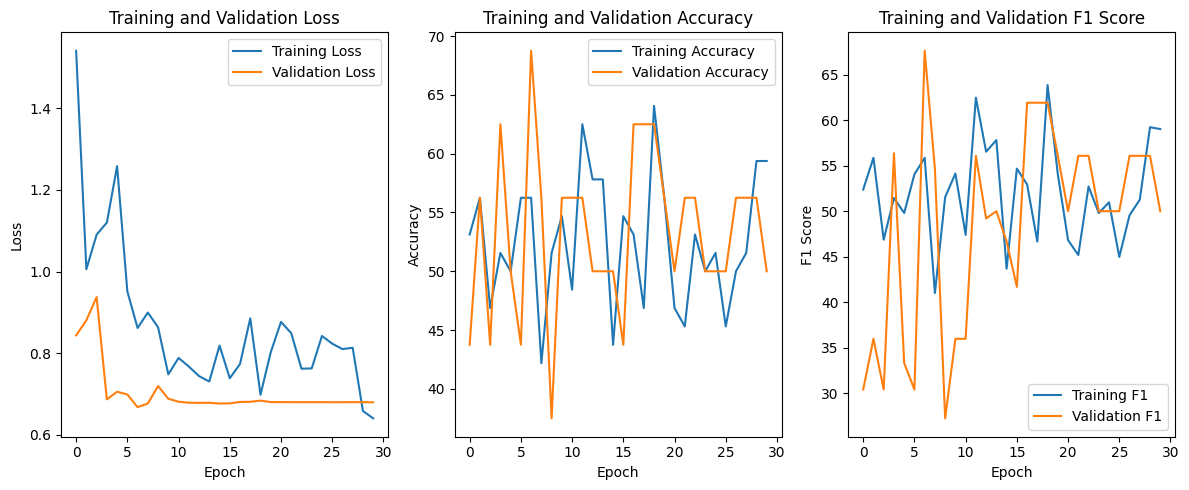

In [30]:
def main():
    # Set up configurations
    seed_everything(config.seed)
    num_classes = 2
    input_size = (3, 256, 256)
    
    # Initialize model, criterion, optimizer, and scheduler
    model = Early_fusion(num_classes=num_classes, input_size=input_size, features_grad=False).to(config.device)
    criterion = nn.CrossEntropyLoss().to(config.device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    # Initialize training and validation histories
    best_val_loss = float("inf")
    history = {
      "train": {"loss": [], "acc": [], "f1": []},
      "valid": {"loss": [], "acc": [], "f1": []},
    }
    
    print("Starting training...")
    for epoch in range(config.epochs):
        # Train for one epoch
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, config.device)
        valid_loss, valid_acc, valid_f1 = validation(model, valid_loader, criterion, config.device)

        # Save training history
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)
        
        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')

        # Save the best model based on validation loss
        if valid_loss < best_val_loss:
            torch.save({
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }, "checkpoint_Early.pth")
            best_val_loss = valid_loss

    # Load the best model for final validation evaluation
    best_ckpt = torch.load("checkpoint_Early.pth", map_location=config.device)
    model.load_state_dict(best_ckpt["model"])
    
    valid_loss, valid_acc, valid_f1 = validation(model, valid_loader, criterion, config.device)
    print("*" * 10, "Final Validation", "*" * 10)
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%")
    
    # Plot training history
    plot_training_history(history)

    # Clean up resources
    # del train_loader, valid_loader
    gc.collect()
    torch.cuda.empty_cache()

if __name__ == "__main__":
    main()

In [31]:
model = Early_fusion(num_classes = 2, features_grad = True)
model.to("cuda")
best_ckpt = torch.load(f"checkpoint_Early.pth")
model.load_state_dict(best_ckpt["model"])
preds = testing(model, test_loader, config.device)

results_df = pd.read_csv(os.path.join(config.root, "submission.csv"))
results_df['Disease'] = preds.cpu().numpy() 
results_df.to_csv("Early.csv", index=False)
results_df

,ID,Disease
0,1035303,0
1,1032110,0
2,3158,0
3,759590,1
4,903423,1
5,629424,0
6,984633,0
7,908999,1
8,11338,0
9,1070273,0


In [32]:
# 清理資源
# del train_loader, valid_loader, train_dataset, valid_dataset
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()  # 重置最大内存分配统计

# 3D CNN







## 3D Dataset

In [33]:
class config:

    root = "/kaggle/input/mia-hw-3"
    valid_prob = 0.2
    batch_size = 4
    lr = 5e-3  # Higher starting learning rate
    epochs = 30  # Reduced epoch count
    weight_decay = 1e-3  # Increased weight decay
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42
    
print(config.device)

cuda


In [34]:
class MRI3DDataset(torch.utils.data.Dataset):
    def __init__(self, df, mode = None, transforms = None):
        
        root = "/kaggle/input/mia-hw-3"
        self.ids = np.array(df["ID"])
        self.labels = torch.tensor(df["Disease"].values) 
        self.mode = mode
        self.transforms = transforms
        
        paths = []
        for ID in self.ids:
            path = os.path.join(root, "DICOM", str(ID).split('.')[0].zfill(7))
            paths.append(path)
        
        self.images = []
        
        for path in tqdm(paths):
            all_slices = []
            T1_root = os.path.join(path, "T1")
            T2_root = os.path.join(path, "T2")
            for filename in sorted(os.listdir(T1_root), key = lambda s: int(pydicom.dcmread(os.path.join(T1_root, s)).InstanceNumber)):
                T1_image = []
                T2_image = []
                
                # T1 images
                img = pydicom.dcmread(os.path.join(T1_root, filename))
                ww = img.WindowWidth
                wc = img.WindowCenter
                highest_visible_value = (ww + 2 * wc) / 2
                lowest_visible_value = highest_visible_value - ww
                
                img = img.pixel_array
                img = np.clip(img, lowest_visible_value, highest_visible_value)
                img = 255 * (img - lowest_visible_value) / ww
                img = cv2.resize(img, (256, 256))
                
                T1_image.append(img) 
                
                # T2 images
                img = pydicom.dcmread(os.path.join(T2_root, filename))
                ww = img.WindowWidth
                wc = img.WindowCenter
                highest_visible_value = (ww + 2 * wc) / 2
                lowest_visible_value = highest_visible_value - ww
                
                img = img.pixel_array
                img = np.clip(img, lowest_visible_value, highest_visible_value)
                img = 255 * (img - lowest_visible_value) / ww
                img = cv2.resize(img, (256, 256))
                
                T2_image.append(img)
                
                # T1T2 images
                T1T2_image = (T1_image[0] + T2_image[0]) / 2
                T1T2_image = torch.tensor(T1T2_image)
                
                T1_image = torch.tensor(T1_image[0])
                T2_image = torch.tensor(T2_image[0])
                
                all_slices.append(torch.stack((T1_image, T2_image, T1T2_image), dim = 0)) 
                # 其中 torch.stack((T1_image, T2_image, T1T2_image), dim = 0) 的形狀是 (3, 512, 512)
            
            slices = torch.stack(all_slices, dim = 1) # (3, XX, 512, 512) XX為原始切片數量
            
            if self.transforms:
                slices = self.transforms(slices) # (22, 3, 256, 256)
                slices = torch.transpose(slices, 0, 1) # (3, 22, 256, 256)
            
            self.images.append(slices.float())
    
    def __getitem__(self, index):
        
        if self.mode == "train":
            
            images = self.images[index]
            label = self.labels[index]    
            
            return images, label
        
        elif self.mode == "valid":
            
            images = self.images[index]
            label = self.labels[index]
            
            return images, label
        
        elif self.mode == "test":
            
            images = self.images[index]
            
            return images
    
    def __len__(self):
        return(len(self.ids))

## 3D CNN model







[MedicalNet](https://github.com/Tencent/MedicalNet/tree/master)







[pretrained.pth](https://www.kaggle.com/datasets/werus23/medicalnet)

In [35]:
# 載入github資源
!git clone https://github.com/Tencent/MedicalNet.git
import sys
sys.path.append('/kaggle/working/MedicalNet')
from MedicalNet.models import resnet

Cloning into 'MedicalNet'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 120 (delta 50), reused 43 (delta 43), pack-reused 51 (from 1)
Receiving objects: 100% (120/120), 47.63 MiB | 44.63 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [36]:
# 層數可自行決定
def generate_model(model_type='resnet', model_depth=50,
                   input_W=224, input_H=224, input_D=224, shortcut_type='B',
                   no_cuda=True, gpu_id=[0],
                   pretrain_path = '/kaggle/input/resnet50/pretrain/resnet_50.pth',
                   nb_class=1):

    # shortcut_type = "B"在 ResNet 中指的是一種捷徑（shortcut）連接方法，用來讓輸入和輸出尺寸一致。
    
    # 因為我們是調用上面 github 提供的模型，因為只有提供 resnet 所以這邊確認 model_type 是 resnet
    assert model_type in [
        'resnet'
    ]
    # 當 model_type 確認為 resnet 時，再檢查 model_depth 是否在指定的範圍內（10、18、34、50、101、152、200）
    if model_type == 'resnet':
        assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    model = resnet.resnet50(sample_input_W=input_W, sample_input_H=input_H, sample_input_D=input_D, num_seg_classes = nb_class)

    # 修改原本的 conv_seg 模組來應用到我們的分類任務
    model.conv_seg = nn.Sequential(nn.AdaptiveAvgPool3d((1, 1, 1)), nn.Flatten())
    # nn.AdaptiveAvgPool3d((1, 1, 1))：這層會將輸入的 feature map 進行 Global Average Pooling，將維度 (D, H, W) 縮小到 (1, 1, 1)。最終輸出會是形狀 (batchsize, channels, 1, 1, 1)
    # nn.Flatten()：將 pooling 後的輸出攤成一個二維向量，形狀是 (batchsize, channels)
    
    
    if not no_cuda:
        if len(gpu_id) > 1:
            model = model.cuda()
            model = nn.DataParallel(model, device_ids=gpu_id)
            net_dict = model.state_dict()
        else:
            import os
            os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu_id[0])
            model = model.cuda()
            model = nn.DataParallel(model, device_ids=None)
            net_dict = model.state_dict()
    else:
        net_dict = model.state_dict()

    print('loading pretrained model {}'.format(pretrain_path))
    pretrain = torch.load(pretrain_path)
    pretrain_dict = {k: v for k, v in pretrain['state_dict'].items() if k in net_dict.keys()}

    net_dict.update(pretrain_dict)

    return model

In [37]:
class Resnet3d(nn.Module):
    def __init__(self, num_classes, features_grad = False):
        super().__init__()

         # 用上方定義 generate_model 函數生成一個預訓練的 3D ResNet50 模型。
        resnet50_3d = generate_model(model_type='resnet', model_depth=50,
                         input_W=256, input_H=256, input_D=22, shortcut_type='B',
                         pretrain_path = "/kaggle/input/resnet50/pretrain/resnet_50.pth",
                         nb_class=2)

        resnet50_3d.classifier = nn.Identity()

        for param in resnet50_3d.parameters():
            param.requires_grad = features_grad 
            
        # 更改成 3 channel
        temp = [param for param in resnet50_3d.conv1.parameters()][0] # (64, 1, 7, 7, 7)
        temp = torch.cat((temp, temp, temp), dim = 1) # (64, 3, 7, 7, 7)
        resnet50_3d.conv1 = nn.Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
        for param in resnet50_3d.conv1.parameters():
            param = temp

        self.backend = resnet50_3d
        
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x): # x 是一個 (batchsize, 3, 22, 256, 256) 的 tensor
        if type(x) == list:
            x = torch.stack(x, dim=0)
        output = self.backend(x)
        outputs = self.classifier(output)
        return outputs

In [38]:
model_3d = Resnet3d(num_classes = 2)
total_params = sum(p.numel() for p in model_3d.parameters())
print("總參數量:", total_params)
del model_3d

loading pretrained model /kaggle/input/resnet50/pretrain/resnet_50.pth
總參數量: 47250114


100%|██████████| 16/16 [00:06<00:00,  2.29it/s]


Initializing model...
num_classes 2
loading pretrained model /kaggle/input/resnet50/pretrain/resnet_50.pth
Epoch[1/30], Train Loss: 0.7682, Train Accuracy: 50.00%, Train F1: 49.95% | Valid Loss: 0.7718, Valid Accuracy: 56.25%, Valid F1: 36.00% | LR: 0.000201
Epoch[2/30], Train Loss: 0.7074, Train Accuracy: 51.56%, Train F1: 50.98% | Valid Loss: 0.7476, Valid Accuracy: 56.25%, Valid F1: 51.52% | LR: 0.000202
Epoch[3/30], Train Loss: 0.7575, Train Accuracy: 51.56%, Train F1: 50.59% | Valid Loss: 0.7034, Valid Accuracy: 56.25%, Valid F1: 36.00% | LR: 0.000205
Epoch[4/30], Train Loss: 0.6617, Train Accuracy: 57.81%, Train F1: 57.30% | Valid Loss: 0.6519, Valid Accuracy: 62.50%, Valid F1: 56.36% | LR: 0.000209
Epoch[5/30], Train Loss: 0.6600, Train Accuracy: 54.69%, Train F1: 54.14% | Valid Loss: 0.6422, Valid Accuracy: 62.50%, Valid F1: 56.36% | LR: 0.000214
Epoch[6/30], Train Loss: 0.6864, Train Accuracy: 62.50%, Train F1: 62.17% | Valid Loss: 0.6619, Valid Accuracy: 62.50%, Valid F1: 56.

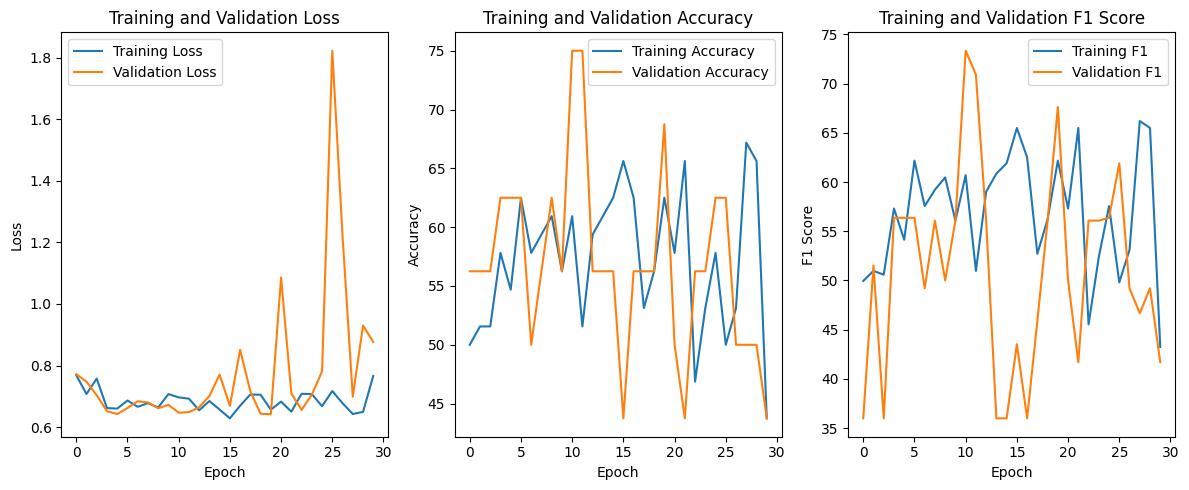

In [39]:
def main():

    seed_everything(config.seed)

    df = pd.read_csv(os.path.join(config.root, "train.csv"))
    
    # split training & validation dataset 
    n = df.shape[0]
    valid_size = int(n * config.valid_prob)
    train_ids , valid_ids = train_test_split(
     np.linspace(0, n - 1, n).astype("int"),
     test_size = valid_size,
     random_state = config.seed,
    )
    
    # DataLoader
    train_data = df.iloc[train_ids]
    valid_data = df.iloc[valid_ids]
    train_dataset = MRI3DDataset(train_data, mode = "train", transforms = build_transform(True))
    valid_dataset = MRI3DDataset(valid_data, mode = "valid", transforms = build_transform(False))
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)

    
    # settings
    print("Initializing model...")
    num_classes = 2
    print('num_classes',num_classes)
    model = Resnet3d(num_classes = num_classes, features_grad = False)
    model.to(config.device)
    criterion = nn.CrossEntropyLoss().to(config.device)

    # 選擇適當的 optimizer, scheduler
    # optimizer = torch.optim.Adam(model.parameters(), lr = config.lr, weight_decay = config.weight_decay)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    #     optimizer, T_0=10, T_mult=2, eta_min=1e-6  # Cosine annealing with restarts
    # )
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer = optimizer,
        epochs = config.epochs,
        steps_per_epoch = train_loader.__len__(),
        max_lr = config.lr,
        anneal_strategy = 'cos'
    )

    # recordings
    best_val_loss = float("inf")
    history = {
      "train": {
          "loss": [],
          "acc": [],
          "f1": []
      },
      "valid": {
          "loss": [],
          "acc": [],
          "f1": []
      },
    }

    for epoch in range(config.epochs):
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, config.device)
        valid_loss, valid_acc, valid_f1 = validation(model, valid_loader, criterion, config.device)

        # Log the loss and validation result
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)

        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')

        if valid_loss < best_val_loss:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpoint_3D.pth")

        best_ckpt = torch.load("checkpoint_3D.pth", map_location=config.device)
        model.load_state_dict(best_ckpt["model"])

    valid_loss, valid_acc, valid_f1 = validation(model, valid_loader, criterion, config.device)
    print("*"*10, " Validation ", "*"*10)
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%")
    
    del train_dataset
    del valid_dataset
    del train_loader
    del valid_loader
    gc.collect()
    torch.cuda.empty_cache()
    
    plot_training_history(history)

if __name__ == "__main__":
    main()

In [40]:
test_df = pd.read_csv(os.path.join(config.root, "test.csv"))
test_dataset = MRI3DDataset(test_df, mode = "test", transforms = build_transform(False))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

model = Resnet3d(num_classes = 2).to("cuda")

best_ckpt = torch.load("checkpoint_3D.pth", map_location=config.device)
model.load_state_dict(best_ckpt["model"])

preds = testing(model, test_loader, config.device)

results_df = pd.read_csv(os.path.join(config.root, "submission.csv"))
results_df['Disease'] = preds.cpu().numpy() 
results_df.to_csv("3D.csv", index=False)
results_df

100%|██████████| 40/40 [00:17<00:00,  2.29it/s]


loading pretrained model /kaggle/input/resnet50/pretrain/resnet_50.pth


,ID,Disease
0,1035303,0
1,1032110,0
2,3158,1
3,759590,1
4,903423,0
5,629424,1
6,984633,1
7,908999,0
8,11338,1
9,1070273,1


In [41]:
# 清理資源
# del train_loader, valid_loader, train_dataset, valid_dataset
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()  # 重置最大内存分配统计